In this task we have to implement a Decision Tree Classifier for continuous variables.




###Decision Tree Classifier

Now in this assignment we will be implementing the Decision Classifier for both Continuous and Categorical attributes.

Decision tree can be built by using any of the following split criterias, namely:
 - Information Gain
 - Gini Index
 - CART 

However, you are required here to implement the decision tree with information gain as splitting criterion.

Remember in my code i am not looking for maximizing the information gain, instead i am looking for minimizing the split entropy. Recall,
$$Information Gain  = H(D) - H(D_Y,D_N)$$

Where,

$H(D)$ is the data set entroy and $H(D_Y,D_N)$ is split entropy. Since $H(D)$ is constant for the given dataset so maximizing the entropy is equal to minimizing the split entropy and that is what is being represented in my code outputs.

In [7]:
%pylab inline
import scipy.stats
from collections import defaultdict  # default dictionary 

Populating the interactive namespace from numpy and matplotlib


In [8]:
#Cutomize the Matplotlib for beautiful plots...
import dmStyle
dmStyle.customize_mpl()


Setting custom matplotlib visual style


In [9]:
import math
import pandas as pd
import numpy as np

In [10]:
class Node:
    def __init__(self, purity,klasslabel='',score=0,split=[],fidx=-1):
        
        self.lchild=None       
        self.rchild=None
        self.klasslabel=klasslabel        
        self.split=split
        self.score=score
        self.fidx=fidx
        self.purity=purity
        
    def set_childs(self,lchild,rchild):

        self.rchild = rchild
        self.lchild = lchild
        
    def isleaf(self):

        if self.lchild == None and self.lchild == None:
            return True
        else:
            return False
        
    def isless_than_eq(self, X):

        if X <= self.split:
            return True
        else:
            return False
        
    def get_str(self):

        if self.isleaf():
            return 'C(class={},Purity={})'.format(self.klasslabel,self.purity)
        else:
            return 'I(Fidx={},Score={},Split={})'.format(self.fidx,self.score,self.split)
    

In [24]:
class DecisionTree:

    def __init__(self, purityp, exthreshold, maxdepth=10):        

        self.purity=purityp
        self.exthreshold=exthreshold
        self.maxdepth=maxdepth
        pass
    def train(self, X, Y):
        
        nexamples,nfeatures=X.shape
        self.tree = self.build_tree(X, Y)
        
    def printing(self, node):
        
        if node.lchild == None and node.rchild == None:
            print node.get_str()
        else:
            print node.get_str()
            self.printing(node.lchild)
            self.printing(node.rchild)
        
    def test(self, X):
        
        nexamples, nfeatures=X.shape
        pclasses=self.predict(X)
        
        return np.array(pclasses)
    
    def evaluate_numerical_attribute(self,feat, Y):
        classes=np.unique(Y)
        nclasses=len(self.classes)
        
        sidx=np.argsort(feat) # sorted index of features
        f=feat[sidx] # sorted features
        sY=Y[sidx] # sorted features class labels...

        self.evl_tree(X, Y)
        return 0,0,0,0
    
    def predict(self, X):
        
        z=[]
        for idx in range(X.shape[0]):
            curr_class = self._predict(self.tree,X[idx,:])
            if curr_class != "" or curr_class != None:
                z.append(curr_class)
        return z
    
    def _predict(self,node, X):
        
        if node.isleaf():
            return node.klasslabel
        else:
            if X[node.fidx] <= node.split:
                return self._predict(node.lchild, X)
            else:
                return self._predict(node.rchild, X)

    def __str__(self):
       
        return self.__print(self.tree)
    
    def find_depth(self):

        return self._find_depth(self.tree)
    
    def _find_depth(self,node):
    
        if not node:
            return
        if node.isleaf():
            return 1
        else:
            return max(self._find_depth(node.lchild),self._find_depth(node.rchild)) + 1
        
    def __print(self,node,depth=0):
        
        ret = ""
        if node.rchild:
            ret += self.__print(node.rchild,depth+1)
        
        ret += "\n" + ("    "*depth) + node.get_str()

        if node.lchild:
            ret += self.__print(node.lchild,depth+1)
        
        return ret   
    
    def build_tree(self, X, Y, depth=0):
        
        no_of_example, no_of_feature = X.shape
        classes = np.unique(Y)
        
        if depth <= self.maxdepth:
            class_probs = [(float(len(Y[Y == c])) / no_of_example) for c in classes]
            purity = max(class_probs)
            print "Current Purity = ", purity, " , Nexamples = ", no_of_example
            
            node = None
            if no_of_example <= self.exthreshold or purity >= self.purity:
                curr_class = classes[np.argmax(class_probs)]
                node = Node(purity, klasslabel=curr_class, score=0, split=[], fidx=-1)
                no_of_example_classwise = {}
                
                for c in range(len(classes)):
                    no_of_example_classwise[classes[c]] = class_probs[c] * no_of_example
                    
                print "Creating Child Node With Purity = ", node.purity, ", ClassLabel = ", node.klasslabel, ", nexamples = ", no_of_example, ", classes = , ", no_of_example_classwise.items() 
                return node

            node, D_y, D_y_labels, D_n ,D_n_labels = self.make_tree(X, Y)
            node.set_childs(self.build_tree(D_y, D_y_labels, depth + 1), self.build_tree(D_n, D_n_labels, depth + 1))
            print "Creating Parent Node For Feature = ", node.fidx, ", with Split = ", node.split, ", and Score = ", node.score
            print "Creating Left Child Node With ", len(D_y), " and Right Child Node With ", len(D_n), " Examples"
            return node    
    
    def make_tree(self, X, Y):
        
        no_of_example, no_of_feature = X.shape
        classes = np.unique(Y)
        
    # ------ Calculating P(c) -> Probability of classes
        class_probs = [(float(len(Y[Y == c])) / no_of_example) for c in classes]

    # ------ Making list of count of each class
        n = [class_probs[p] * no_of_example for p in range(len(class_probs))]

    # ------ Calculating Entropy of DataSet
        H_D = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in class_probs])

    # ------ Splitting 

        N = []
        split_point = 0
        column_max = -1
        column_max_idx = -1
        column_row_max_idx = -1
        for j in range(no_of_feature):
            row_max = -1
            row_max_idx = -1
            for i in range(no_of_example):
                N = [0] * len(classes)
                split_point = X[i][j]

    # ------ Calculating N -> List of Number of elements that belong to a particular class                
                for k in range(no_of_example):
                    if X[k][j] <= split_point:
                        for ci in range(len(classes)):
                            if Y[k] == classes[ci]:
                                N[ci] = N[ci] + 1
                                break

    # ------ Calculating Probabilities of Right and Left Sub-DataSet of the split point
                P_dy = [float(N[p]) / sum(N) for p in range(len(N))]
                P_dn = [float(n[p] - N[p]) / sum([q - r for q, r in zip(n, N)]) for p in range(len(N))]

    # ------ Calculating Entropy of Right and Left Sub-DataSet of the split point
                H_dy = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in P_dy if cp != 0])
                H_dn = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in P_dn if cp != 0])

    # ------ Split Entropy
                H_dyn = (float(sum(N)) / no_of_example) * H_dy + (float(no_of_example - sum(N)) / no_of_example) * H_dn
                
    # ------ Gain
                Gain = H_D - H_dyn
                if row_max < Gain:
                    row_max = Gain
                    row_max_idx = i
                
            if column_max < row_max:
                column_max = row_max
                column_max_idx = j
                column_row_max_idx = row_max_idx
            
        D_y = [row for row in X if row[column_max_idx] <= X[column_row_max_idx][column_max_idx]]
        D_y_labels = [Y[l] for l in range(len(Y)) if X[l][column_max_idx] <= X[column_row_max_idx][column_max_idx]]
        
        D_n = [row for row in X if row[column_max_idx] > X[column_row_max_idx][column_max_idx]]
        D_n_labels = [Y[l] for l in range(len(Y)) if X[l][column_max_idx] > X[column_row_max_idx][column_max_idx]]

        node = Node(1.0 - H_D, Y[column_row_max_idx], column_max, X[column_row_max_idx][column_max_idx], column_max_idx)
        return node, np.array(D_y), np.array(D_y_labels), np.array(D_n) ,np.array(D_n_labels)
    
    def evl_tree(self, X, Y):
        
        no_of_example, no_of_feature = X.shape
        classes = np.unique(Y)
        
    # ------ Calculating P(c) -> Probability of classes
        class_probs = [(float(len(Y[Y == c])) / no_of_example) for c in classes]

    # ------ Making list of count of each class
        n = [class_probs[p] * no_of_example for p in range(len(class_probs))]

    # ------ Calculating Entropy of DataSet
        H_D = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in class_probs])

    # ------ Splitting 

        N = []
        split_point = 0
        column_max = -1
        column_max_idx = -1
        column_row_max_idx = -1
        for j in range(no_of_feature):
            row_max = -1
            row_max_idx = -1
            for i in range(no_of_example):
                N = [0] * len(classes)
                split_point = X[i][j]

    # ------ Calculating N -> List of Number of elements that belong to a particular class                
                for k in range(no_of_example):
                    if X[k][j] <= split_point:
                        for ci in range(len(classes)):
                            if Y[k] == classes[ci]:
                                N[ci] = N[ci] + 1
                                break

    # ------ Calculating Probabilities of Right and Left Sub-DataSet of the split point
                P_dy = [float(N[p]) / sum(N) for p in range(len(N))]
                P_dn = [float(n[p] - N[p]) / sum([q - r for q, r in zip(n, N)]) for p in range(len(N))]

    # ------ Calculating Entropy of Right and Left Sub-DataSet of the split point
                H_dy = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in P_dy if cp != 0])
                H_dn = -1 * sum([cp * (math.log(cp) / math.log(2)) for cp in P_dn if cp != 0])

    # ------ Split Entropy
                H_dyn = (float(sum(N)) / no_of_example) * H_dy + (float(no_of_example - sum(N)) / no_of_example) * H_dn
                
    # ------ Gain
                Gain = H_D - H_dyn
                if row_max < Gain:
                    row_max = Gain
                    row_max_idx = i
                
    # ------ Output
                print "Split={}, H(DY)={}, H(DN)={}, Gain={}\n".format(split_point, H_dy, H_dn, Gain)
#                 print "Split={}, H(DY)={}, P(DY)={}, H(DN)={}, P(DN)={}, Gain={}".format(split_point, H_dy, P_dy, H_dn, P_dn, Gain)
                
            if column_max < row_max:
                column_max = row_max
                column_max_idx = j
                column_row_max_idx = row_max_idx

In [12]:
import pandas as pd
import tools as t # set of tools for plotting, data splitting, etc..

In [13]:
#load the data set
data=pd.read_csv('./data/iris.data')
data.columns=['SepalLength','SepalWidth','PetalLength','PetalWidth','Class']
print data.describe()

       SepalLength  SepalWidth  PetalLength  PetalWidth
count   149.000000  149.000000   149.000000  149.000000
mean      5.848322    3.051007     3.774497    1.205369
std       0.828594    0.433499     1.759651    0.761292
min       4.300000    2.000000     1.000000    0.100000
25%       5.100000    2.800000     1.600000    0.300000
50%       5.800000    3.000000     4.400000    1.300000
75%       6.400000    3.300000     5.100000    1.800000
max       7.900000    4.400000     6.900000    2.500000


In [14]:
# Get your data in matrix
X=np.asarray(data[['SepalLength','SepalWidth','PetalLength','PetalWidth']].dropna())
Y=np.asarray(data['Class'].dropna())
print " Data Set Dimensions=", X.shape, " True Class labels dimensions", Y.shape   


 Data Set Dimensions= (149L, 4L)  True Class labels dimensions (149L,)


In [15]:
print Y

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versic

In [16]:
Y[Y=='Iris-virginica']='Iris-versicolor'
print Y, len(Y), np.unique(Y)

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versic

###Debugging Tip
You can import pdb and call its function set_trace (i.e pdb.set_trace()) any where in your code to stop the execution of your 

###First test your implementation that it is working fine...

Specially test that your function "evaluate_numerical_attribute" for the correct results. Lets test it...

In [25]:
print len(Y)
feat=[0,1]
dt=DecisionTree(0.95,5,2)
feat=[0,1]
dt.classes=np.unique(Y)
dt.nclasses=len(np.unique(Y))
split,mingain,Xlidx,Xridx=dt.evaluate_numerical_attribute(X[:,0],Y)

149
Split=4.9, H(DY)=0.439496986922, H(DN)=0.775117650694, Gain=0.188193509123

Split=4.7, H(DY)=-0.0, H(DN)=0.849054424254, Gain=0.127383876931

Split=4.6, H(DY)=-0.0, H(DN)=0.863120568567, Gain=0.102770661815

Split=5.0, H(DY)=0.5435644432, H(DN)=0.678953899519, Gain=0.263879461635

Split=5.4, H(DY)=0.577004250316, H(DN)=0.290715865467, Gain=0.525049239113

Split=4.6, H(DY)=-0.0, H(DN)=0.863120568567, Gain=0.102770661815

Split=5.0, H(DY)=0.5435644432, H(DN)=0.678953899519, Gain=0.263879461635

Split=4.4, H(DY)=-0.0, H(DN)=0.893571101654, Gain=0.0441738152341

Split=4.9, H(DY)=0.439496986922, H(DN)=0.775117650694, Gain=0.188193509123

Split=5.4, H(DY)=0.577004250316, H(DN)=0.290715865467, Gain=0.525049239113

Split=4.8, H(DY)=-0.0, H(DN)=0.808285255679, Gain=0.192266907412

Split=4.8, H(DY)=-0.0, H(DN)=0.808285255679, Gain=0.192266907412

Split=4.3, H(DY)=-0.0, H(DN)=0.909022156088, Gain=0.0108350946896

Split=5.8, H(DY)=0.957863023748, H(DN)=5.39294658626e-15, Gain=0.405896170025

S

In [69]:
feat=[0,1]
dt=DecisionTree(0.95,5)
dt.train(X[:,feat],Y)

Current Purity =  0.671140939597  , Nexamples =  149
Current Purity =  0.862745098039  , Nexamples =  51
Current Purity =  0.857142857143  , Nexamples =  7
Current Purity =  1.0  , Nexamples =  1
Creating Child Node With Purity =  1.0 , ClassLabel =  Iris-setosa , nexamples =  1 , classes = ,  [('Iris-setosa', 1.0)]
Current Purity =  1.0  , Nexamples =  6
Creating Child Node With Purity =  1.0 , ClassLabel =  Iris-versicolor , nexamples =  6 , classes = ,  [('Iris-versicolor', 6.0)]
Creating Parent Node For Feature =  0 , with Split =  4.5 , and Score =  0.591672778582
Creating Left Child Node With  1  and Right Child Node With  6  Examples
Current Purity =  0.977272727273  , Nexamples =  44
Creating Child Node With Purity =  0.977272727273 , ClassLabel =  Iris-setosa , nexamples =  44 , classes = ,  [('Iris-setosa', 43.0), ('Iris-versicolor', 1.0)]
Creating Parent Node For Feature =  1 , with Split =  2.7 , and Score =  0.36078236369
Creating Left Child Node With  7  and Right Child N

In [41]:
print dt


            C(class=Iris-versicolor,Purity=1.0)
        I(Fidx=0,Score=0.954434002925,Split=5.8)
            C(class=Iris-setosa,Purity=1.0)
    I(Fidx=1,Score=0.212802885637,Split=3.4)
        C(class=Iris-versicolor,Purity=1.0)
I(Fidx=0,Score=0.525049239113,Split=5.4)
        C(class=Iris-setosa,Purity=0.977272727273)
    I(Fidx=1,Score=0.36078236369,Split=2.7)
            C(class=Iris-versicolor,Purity=1.0)
        I(Fidx=0,Score=0.591672778582,Split=4.5)
            C(class=Iris-setosa,Purity=1.0)


In [42]:
print dt.find_depth()

4


 Plotting the Decision Surface of Training Set... 
[0 0 0 ..., 1 1 1] <type 'numpy.int64'> False


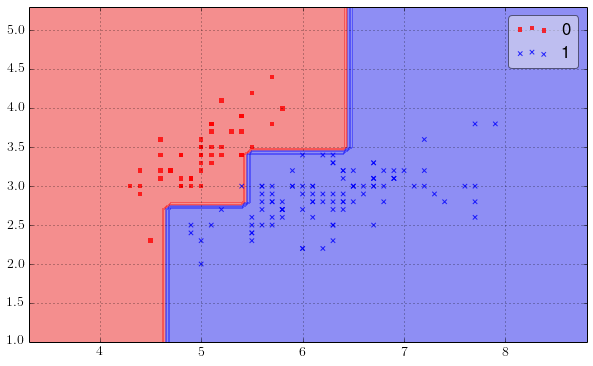

In [14]:
# %pdb
print " Plotting the Decision Surface of Training Set... "
t.plot_decision_regions(X[:,feat],Y,clf=dt, res=0.1, cycle_marker=True, legend=1)

In [43]:
Xtrain,Ytrain,Xtest,Ytest=t.split_data(X,Y)

print " Training Data Set Dimensions=", Xtrain.shape, "Training True Class labels dimensions", Ytrain.shape   
print " Test Data Set Dimensions=", Xtest.shape, "Test True Class labels dimensions", Ytrain.shape   


 Training Data Set Dimensions= (104L, 4L) Training True Class labels dimensions (104L,)
 Test Data Set Dimensions= (45L, 4L) Test True Class labels dimensions (104L,)


In [44]:
# Lets train a Decision Tree Classifier on Petal Length and Width
feat=[0,1]
dt=DecisionTree(0.95,5)
dt.train(Xtrain[:,feat],Ytrain)

In [45]:
#Lets test it on the set of unseen examples...
pclasses=dt.predict(Xtest[:,feat])

#                   0-5.4
#            1-2.7       1-3.4
#     0-4.5      IS    IV      0-5.8
# IS        IV                IS    IV

In [46]:
print pclasses

['Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor']


Lets see how good we are doing...
==================

In [47]:
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "Accuracy = ", np.sum(pclasses==Ytest)/float(Ytest.shape[0])

40
Accuracy =  0.888888888889


 Plotting the Decision Surface of Training Set... 
[0 0 0 ..., 1 1 1] <type 'numpy.int64'> False


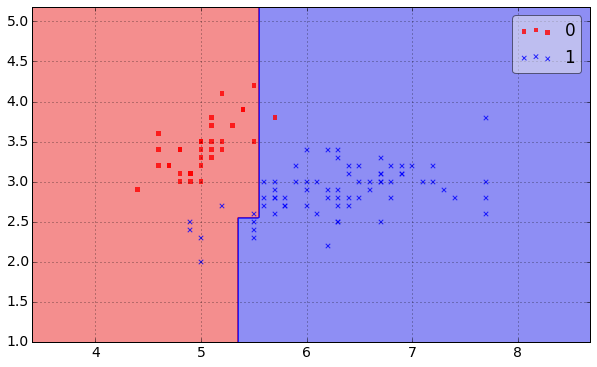

In [20]:
#Lets plot the decision surface
print " Plotting the Decision Surface of Training Set... "
t.plot_decision_regions(Xtrain[:,feat],Ytrain,clf=dt, res=0.02, cycle_marker=True, legend=1)

 Plotting the Decision Surface of Test Set... 
[0 0 0 ..., 1 1 1] <type 'numpy.int64'> False


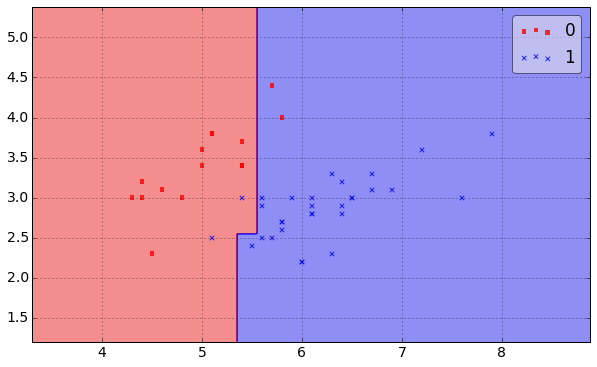

In [21]:
print " Plotting the Decision Surface of Test Set... "
t.plot_decision_regions(Xtest[:,feat],Ytest,clf=dt, res=0.02, cycle_marker=True, legend=1)

#Lets Train on all four features....

In [48]:
#Lets Train on all four features....

# Lets train a Decision Tree Classifier on Petal Length and Width
feat=[0, 1, 2, 3]
dt=DecisionTree(0.95,5)
dt.train(Xtrain[:,feat],Ytrain)
pclasses=dt.predict(Xtest[:,feat])
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "Accuracy = ", np.sum(pclasses==Ytest)/float(Ytest.shape[0])

45
Accuracy =  1.0


#Lets Train on all four features and for all three classes....

In [49]:
X=np.asarray(data[['SepalLength','SepalWidth','PetalLength','PetalWidth']].dropna())
Y=np.asarray(data['Class'].dropna())
print " Data Set Dimensions=", X.shape, " True Class labels dimensions", Y.shape

 Data Set Dimensions= (149L, 4L)  True Class labels dimensions (149L,)


In [50]:
# Split your data into training and test-set... 
# see the documentation of split_data in tools for further information...
Xtrain,Ytrain,Xtest,Ytest=t.split_data(X,Y)

print " Training Data Set Dimensions=", Xtrain.shape, "Training True Class labels dimensions", Ytrain.shape   
print " Test Data Set Dimensions=", Xtest.shape, "Test True Class labels dimensions", Ytrain.shape   


 Training Data Set Dimensions= (104L, 4L) Training True Class labels dimensions (104L,)
 Test Data Set Dimensions= (45L, 4L) Test True Class labels dimensions (104L,)


In [51]:
feat=[0, 1, 2, 3]
dt=DecisionTree(0.95,5)
dt.train(Xtrain[:,feat],Ytrain)
pclasses=dt.predict(Xtest[:,feat])
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "Accuracy = ", np.sum(pclasses==Ytest)/float(Ytest.shape[0])

45
Accuracy =  1.0


In [52]:
nfolds=4 # lets use four folds..
folds=t.generate_folds(X,Y,nfolds)
features=[0,1, 2, 3] # features to use for our system
#now lets train and test on these folds...

#Lets perform the grid search...
purity=np.linspace(0.85,0.97,13) # You can also search over depth as well....
nexamp=np.linspace(5,25,21)  

params=np.zeros((len(purity),len(nexamp)))
                   
for p in range(len(purity)):
    for n in range(len(nexamp)):
        totacc=[]
        for k in range(nfolds):
            dt=DecisionTree(purity[p],nexamp[n])
            dt.train(folds[k][0][:,features],folds[k][1])
            pclasses=dt.predict(folds[k][2][:,features])
            acc=np.sum(pclasses==folds[k][3])/float(folds[k][3].shape[0])
            print "[Info] Fold {} Accuracy = {}".format(k+1, acc)
            totacc.append(acc)
        params[p,n]=np.mean(totacc)
        print totacc, '\nPurity={}, Nexample-threshold={}, Mean Accuracy ={}'.format(purity[p],nexamp[n], np.mean(totacc))

Generating CV data for 3 classes
[Info] Fold 1 Accuracy = 0.916666666667
[Info] Fold 2 Accuracy = 0.972222222222
[Info] Fold 3 Accuracy = 0.916666666667
[Info] Fold 4 Accuracy = 0.944444444444
[0.91666666666666663, 0.97222222222222221, 0.91666666666666663, 0.94444444444444442] 
Purity=0.85, Nexample-threshold=5.0, Mean Accuracy =0.9375
[Info] Fold 1 Accuracy = 0.916666666667
[Info] Fold 2 Accuracy = 0.972222222222
[Info] Fold 3 Accuracy = 0.916666666667
[Info] Fold 4 Accuracy = 0.944444444444
[0.91666666666666663, 0.97222222222222221, 0.91666666666666663, 0.94444444444444442] 
Purity=0.85, Nexample-threshold=6.0, Mean Accuracy =0.9375
[Info] Fold 1 Accuracy = 0.916666666667
[Info] Fold 2 Accuracy = 0.972222222222
[Info] Fold 3 Accuracy = 0.916666666667
[Info] Fold 4 Accuracy = 0.944444444444
[0.91666666666666663, 0.97222222222222221, 0.91666666666666663, 0.94444444444444442] 
Purity=0.85, Nexample-threshold=7.0, Mean Accuracy =0.9375
[Info] Fold 1 Accuracy = 0.916666666667
[Info] Fold 

In [53]:
np.save('dt-cv',params)

In [54]:
print params

[[ 0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375    ]
 [ 0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375    ]
 [ 0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375    ]
 [ 0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375      0.9375      0.9375      0.9375
   0.9375      0.9375      0.9375    ]
 [ 0

In [55]:
print params.shape

(13L, 21L)


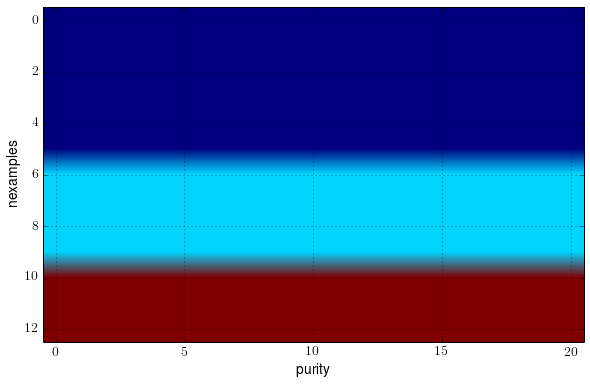

In [48]:
plt.imshow(params) # displayc the accuracy as 2D image...
plt.xlabel('purity')
plt.ylabel('nexamples') # ticks are not aligned..
#plt.xlim(purity.min(),purity.max())
#plt.ylim(nexamp.min(),nexamp.max())

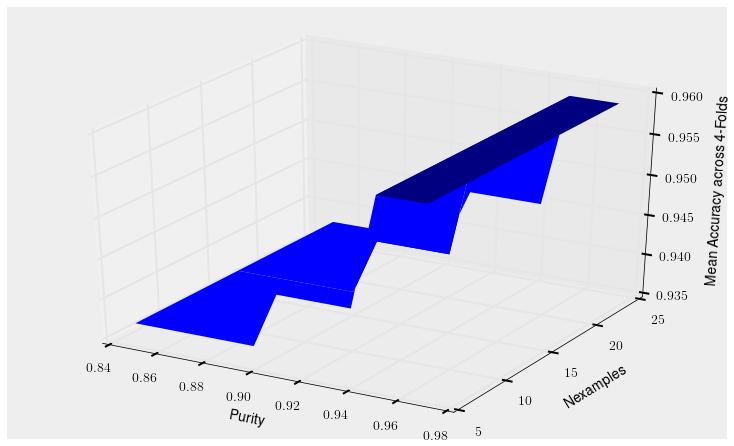

In [34]:
# A more better representation...
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
tX, tY = np.meshgrid(purity, nexamp)
ax.plot_surface(tX,tY,params.T)
ax.set_xlabel('Purity')
ax.set_ylabel('Nexamples')
ax.set_zlabel('Mean Accuracy across {}-Folds'.format(nfolds))
# ax.scatter3D(data['SepalLength'],data['PetalLength'],data['PetalWidth'])
#(params,ax,'Purity','Example-Threshold','Mean-Accuracy')

In [56]:
#print the row and column  index of m
#single line code
ridx,cidx= np.unravel_index(np.argmax(params), params.shape)

# simple step-wise code

cidx=np.argmax(params.max(axis=0))
ridx=np.argmax(params[:,cidx])
print ridx, cidx

10 0


In [57]:
print 'CV Best Parameters are, purity={}, nexamp={}, mean accuracy={}'.format(purity[ridx],nexamp[cidx],params[ridx,cidx])

CV Best Parameters are, purity=0.95, nexamp=5.0, mean accuracy=0.951388888889


This is the true representative accuracy measure of our system. Since, we are removing the selection bias and hence can be much more confidently use the score as a reflection of our system's performance.